<a href="https://colab.research.google.com/github/FMagnani/Physics_Informed_NeuralNetwork/blob/main/Schrodinger_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting conda environment - optional  

The following must be the first executable cell.  
Info: https://colab.research.google.com/drive/1c_RGCgQeLHVXlF44LyOFjfUW32CmG6BP#scrollTo=LAZ11nESX6qt

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


Clone GitHub repo with conda environment configuration file.

In [86]:
!git clone https://github.com/FMagnani/Physics_Informed_NeuralNetwork

fatal: destination path 'Physics_Informed_NeuralNetwork' already exists and is not an empty directory.


We create an environment for the project, with the correct set of packages' versions. 

In [3]:
!conda env create -f Physics_Informed_NeuralNetwork/PINN_env.yml


EnvironmentFileNotFound: '/content/gdrive/MyDrive/PINNs_Data/PINN_env.yml' file not found



Activate environment - source activate is deprecated, but conda activate doesn't work.

In [4]:
!source activate PINN

Could not find conda environment: PINN
You can list all discoverable environments with `conda info --envs`.



# Requirements setting

Importing Data from GitHub repo.  
*This step is not needed if you built the conda environment.*

In [85]:
!git clone https://github.com/FMagnani/Physics_Informed_NeuralNetwork

Cloning into 'Physics_Informed_NeuralNetwork'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 195 (delta 56), reused 195 (delta 56), pack-reused 0
Receiving objects: 100% (195/195), 25.47 MiB | 40.94 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [72]:
data_location = 'Physics_Informed_NeuralNetwork/Data/NLS.mat'

Install pyDOE.  
(I think it's needed even if you created the conda environment)

In [73]:
!pip install pyDOE

Import needed packages

In [74]:
# For the main script
import numpy as np
import tensorflow as tf
import scipy.io
from pyDOE import lhs 
#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

# For the class implementation
import time
from tqdm import tqdm

# For the LBFGS module
import types


# LBFGS module  
  
Adapted from https://github.com/pierremtb/PINNs-TF2.0


In [75]:
# Adapted by https://github.com/pierremtb/PINNs-TF2.0
# from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

#import tensorflow as tf
#import numpy as np
#import time
#import types

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """
  
  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

  # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []

  start_time = time.time()
  while nIter < maxIter:
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      # g_old and t variables are not defined yet, but this else will not 
      # activate in the first run. They're defined later.
      y = g - g_old     
      s = d*t           
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval
    
    # logging iteration time
    if (nIter%10==0):
      time_elapsed = time.time()-start_time
      print('iteration', nIter, '   ',str(time_elapsed)[:4],'sec for 10 it')
      start_time = time.time()
  

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

# Class implementation

Definitions of the Neural Network class and of all the functions and routines.

In [76]:

class neural_net(tf.keras.Sequential):
    
    def __init__(self, ub, lb, layers):
        super(neural_net, self).__init__()
        
#        layers is something like [2, 100, 100, 100, 100, 2]
       
        tf.keras.backend.set_floatx('float64')
        
        self.lb = lb
        self.ub = ub

        self.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))

        self.add(tf.keras.layers.Lambda(
                        lambda X: 2.0*(X-self.lb)/(self.ub-self.lb)-1.0))

        for width in layers[1:-1]:
            self.add(tf.keras.layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer="glorot_normal"))
        
        self.add(tf.keras.layers.Dense(
                layers[-1], activation=None,
                kernel_initializer="glorot_normal"))

        
        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))


    def get_weights(self, convert_to_tensor=True):
        w = []
        for layer in self.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        if convert_to_tensor:
            w = tf.convert_to_tensor(w)
        return w


    def set_weights(self, w):
        for i, layer in enumerate(self.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)


class neural_net_2out(neural_net):
    
    def __init__(self, ub, lb, layers):
        super(neural_net_2out, self).__init__(ub, lb, layers)

    def call(self, inputs, training=False):
        output = super(neural_net_2out, self).call(inputs)
        
        return output[:,0], output[:,1]



class Schrodinger_PINN():
    
    def __init__(self, x0, u0, v0, x_ub, x_lb, t_b, x_f, t_f, X_star, ub, lb, layers):
        
        self.model = neural_net_2out(ub, lb, layers)        
        
        self.x0 = x0
        self.t0 = 0*x0
        self.u0 = u0
        self.v0 = v0
        self.x_lb = x_lb
        self.x_ub = x_ub
        self.t_ub = t_b
        self.t_lb = t_b
        self.x_f = x_f
        self.t_f = t_f
        self.X_star = X_star
        
    
    def train(self, n_iterations, optimizer=tf.keras.optimizers.Adam()):
    
        start_time = time.time()    
        #Train step
        for _ in tqdm(range(n_iterations)):
            self.train_step(optimizer)
        elapsed = time.time() - start_time                
        print('Training time: %.4f' % (elapsed))
    
        
    def train_step(self, optimizer):
        
        with tf.GradientTape() as tape:
            loss_value = self.loss(self.x0,self.t0, self.u0,self.v0)
 
        grads = tape.gradient(loss_value, self.model.trainable_variables)    
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
  
        
    def loss(self, x0,t0, u0,v0):
    
        # Loss from supervised learning (at t=0)
        X0 = tf.stack([x0, t0], axis=1)
        u_pred, v_pred = self.model(X0)
        y0 = tf.reduce_mean(tf.square(u0 - u_pred)) + \
             tf.reduce_mean(tf.square(v0 - v_pred))
    
        # Loss from Schrodinger constraint (at the anchor pts)
        f_u, f_v = self.net_f_uv()
        yS = tf.reduce_mean(tf.square(f_u)) + \
              tf.reduce_mean(tf.square(f_v))
          
        # Loss from boundary conditions
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb)
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub)
    
        yB = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) + \
             tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) + \
             tf.reduce_mean(tf.square(u_x_lb_pred - u_x_ub_pred)) + \
             tf.reduce_mean(tf.square(v_x_lb_pred - v_x_ub_pred))
    
        return y0 + yS + yB
#        return y0


    def net_uv(self, x, t):
    
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            X = tf.stack([x, t], axis=1) # shape = (N_f,2)
        
            u, v = self.model(X)
         
        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)

        return u, v, u_x, v_x

   
    def net_f_uv(self):
        
        x_f = self.x_f
        t_f = self.t_f
        
        with tf.GradientTape(persistent=True) as tape:    
            tape.watch(x_f)
            tape.watch(t_f)
            X_f = tf.stack([x_f, t_f], axis=1) # shape = (N_f,2)
            
            u, v = self.model(X_f)
                
            u_x = tape.gradient(u, x_f)
            v_x = tape.gradient(v, x_f)
            
        u_t = tape.gradient(u, t_f)
        v_t = tape.gradient(v, t_f)        
            
        u_xx = tape.gradient(u_x, x_f)
        v_xx = tape.gradient(v_x, x_f)
    
        del tape
    
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v    
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
    
        return f_u, f_v

     
    def predict(self, x, t):
                
        with tf.GradientTape(persistent=True) as tape:    
            tape.watch(x)
            tape.watch(t)
            X = tf.stack([x, t], axis=1) # shape = (N_f,2)
            
            u, v = self.model(X)
                
            u_x = tape.gradient(u, x)
            v_x = tape.gradient(v, x)
            
        u_t = tape.gradient(u, t)
        v_t = tape.gradient(v, t)        
            
        u_xx = tape.gradient(u_x, x)
        v_xx = tape.gradient(v_x, x)
    
        del tape
    
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v    
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
    
        return u, v, f_u, f_v


#%%


class Schrod_PINN_LBFGS(Schrodinger_PINN):
    
    def __init__(self, x0, u0, v0, x_ub, x_lb, t_b, x_f, t_f, X_star, ub, lb, layers):
        super(Schrod_PINN_LBFGS, self).__init__(x0, u0, v0, x_ub, x_lb, t_b, x_f, t_f, X_star, ub, lb, layers)
    
        # Setting up the optimizers with the hyper-parameters
        self.nt_config = Struct()
        self.nt_config.learningRate = 1.2
        self.nt_config.maxIter = 50
        self.nt_config.nCorrection = 50
        self.nt_config.tolFun = 1.0 * np.finfo(float).eps
    

    def train(self, ADAM_iterations, LBFGS_max_iterations=500, optimizer=tf.keras.optimizers.Adam()):
            
        # ADAM training
        if (ADAM_iterations):
          super(Schrod_PINN_LBFGS, self).train(ADAM_iterations)
            
        # LBFGS trainig
        if (LBFGS_max_iterations):
          self.LBFGS_training(LBFGS_max_iterations)


    def LBFGS_training(self, max_iterations):
        
        self.nt_config.maxIter = max_iterations
        
        lbfgs(self.loss_and_flat_grad,
              self.model.get_weights(),
              self.nt_config, Struct())
        
    
    def loss_and_flat_grad(self, w):
        
        with tf.GradientTape() as tape:
            self.model.set_weights(w)
            loss_value = self.loss(self.x0,self.t0, self.u0,self.v0)
        grad = tape.gradient(loss_value, self.model.trainable_variables)
        grad_flat = []
        for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
        grad_flat = tf.concat(grad_flat, 0)
        return loss_value, grad_flat

    


# Main script - model inizialization and training

Data are imported.  
An instance of the Neural Network is created, that will be trained in the following cell. In this way, the cell used for the training can be run many times to improve each time the current training. 

In [77]:
# Set random seed
np.random.seed(1234)
tf.random.set_seed(1234)
    
# Domain bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50     # Number of training pts from x=0
N_b = 50    # Number of training pts from the boundaries
N_f = 20000 # Number of training pts from the inside - anchor pts

  ########################################
  ##       DATA PREPARATION             ##
  ########################################
     
# Import data
data = scipy.io.loadmat(data_location)

    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
# Creation of the 2D domain
X, T = np.meshgrid(x,t)
    
# The whole domain flattened, on which the final prediction will be made
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
    
# Choose N0 training points from x and the corresponding u, v at t=0
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
# Choose N_b training points from the time
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
    
# Latin Hypercube Sampling of N_f points from the interior domain
X_f = lb + (ub-lb)*lhs(2, N_f)

# 2D locations on the domain of the boundary training points
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
                   
# Recap
    
# Initial condition pts - the real supervised learning pts
# Their 'labels' are u0, v0
# shape = (N0,1)
x0 = X0[:,0:1]
t0 = X0[:,1:2]

# Boundary pts used for constraint
# shape = (N_b,1)
x_lb = X_lb[:,0:1]
t_lb = X_lb[:,1:2]

x_ub = X_ub[:,0:1]
t_ub = X_ub[:,1:2]
        
# Anchor pts for supervised learning
# shape = (N_f,1)
x_f = X_f[:,0:1]
t_f = X_f[:,1:2]    
    
# All these are numpy.ndarray with dtype float64
    
# Conversion to tensors. Recall to WATCH inside a tape
x0 = tf.convert_to_tensor(x0[:,0])
t0 = tf.convert_to_tensor(t0[:,0])
u0 = tf.convert_to_tensor(u0[:,0])
v0 = tf.convert_to_tensor(v0[:,0])
x_lb = tf.convert_to_tensor(x_lb[:,0])
t_lb = tf.convert_to_tensor(t_lb[:,0])
x_ub = tf.convert_to_tensor(x_ub[:,0])
t_ub = tf.convert_to_tensor(t_ub[:,0])
x_f = tf.convert_to_tensor(x_f[:,0])
t_f = tf.convert_to_tensor(t_f[:,0])
X_star = tf.convert_to_tensor(X_star)


layers = [2,100,100,100,100,2]
model = Schrod_PINN_LBFGS(x0, u0, v0, x_ub, x_lb, t_ub, x_f, t_f, X_star, ub, lb, layers)


Training. This cell can also be run multiple times.

In [78]:

adam_iterations = 600  # Number of training steps 
lbfgs_max_iterations = 1200 # Max iterations for lbfgs        

# Training
model.train(adam_iterations, lbfgs_max_iterations)


  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [04:06<00:00,  2.43it/s]


Training time: 246.8419
iteration 10     4.050511598587036
iteration 20     4.259068250656128
iteration 30     4.319369792938232
iteration 40     4.369596004486084
iteration 50     4.401697635650635
iteration 60     4.4434661865234375
iteration 70     4.434616804122925
iteration 80     4.459354639053345
iteration 90     4.424383640289307
iteration 100     4.430680513381958
iteration 110     4.454207181930542
iteration 120     4.45623779296875
iteration 130     4.43920636177063
iteration 140     4.449477910995483
iteration 150     4.458633661270142
iteration 160     4.439203262329102
iteration 170     4.435734510421753
iteration 180     4.4422454833984375
iteration 190     4.440509796142578
iteration 200     4.452229738235474
iteration 210     4.452256917953491
iteration 220     4.44450306892395
iteration 230     4.442287445068359
iteration 240     4.430931568145752
iteration 250     4.425796270370483
iteration 260     4.43603515625
iteration 270     4.436618328094482
iteration 280     

Final prediction.  
That's done on the full domain, from which we sampled the training data and the points on which to check the physics constraints.  
X_star -the full domain- can be treated as the *validation data*.

In [79]:
# final prediction
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star[:,0], X_star[:,1])
h_pred = np.sqrt(u_pred**2 + v_pred**2)
                
# final error
u_pred = tf.reshape(u_pred, shape=(51456,1))
v_pred = tf.reshape(v_pred, shape=(51456,1))
h_pred = tf.reshape(h_pred, shape=(51456,1))

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))



Error u: 2.954596e-01
Error v: 4.730112e-01
Error h: 7.173063e-02


# Plotting

Plotting of the figure.  
It shows the prediction on the full domain and three time snapshots showing the comparison of the simulation with the ground truth.   

Text(0.5, 1.0, '$t = 0.98$')

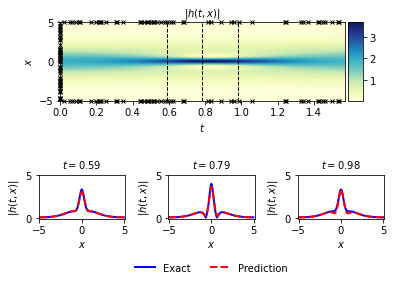

In [80]:
######################################################################
############################# Plotting ###############################
######################################################################    

# Fix for some random bug happening in griddata if all this stuff is not writeable.
X_star_np = X_star.numpy()
h_pred_np = h_pred.numpy()
X_star_np.flags.writeable=True
h_pred_np.flags.writeable=True


H_pred = griddata(X_star_np, h_pred_np[:,0], (X, T), method='cubic')


X0 = tf.stack([x0,0*x0],axis=1) # (x0, 0)
X_lb = tf.stack([0*tb + lb[0], tb], axis=1) # (lb[0], tb)
X_ub = tf.stack([0*tb + ub[0], tb], axis=1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb[:,:,0], X_ub[:,:,0]])
    
 
###########  h(t,x)  ##################    
    
fig1, ax1 = plt.subplots(1,1)
    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax1 = plt.subplot(gs0[:, :])
    
h = ax1.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig1.colorbar(h, cax=cax)
    
ax1.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax1.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax1.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax1.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_title('$|h(t,x)|$', fontsize = 10)
    
 
########   h(t,x) slices ##################    
 
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
    
ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)
    
    
 

# Save figure and weights

Save figure

In [81]:
fig1.savefig('final_results')

*model.model.save* would save the model in a format including the Network architecture.  
*model.model.save_weights* saves the current weights only. They can be loaded by a model that has exactly the same implementation.


In [82]:
model.model.save_weights('./checkpoints/trained_weights')


Zip the folder with weights.

In [83]:
!zip -r /content/check.zip /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/trained_weights.data-00000-of-00001 (deflated 5%)
  adding: content/checkpoints/trained_weights.index (deflated 56%)
  adding: content/checkpoints/checkpoint (deflated 39%)


Downloads the zipped folder.

In [84]:
from google.colab import files
files.download("/content/check.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>